In [4]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import animation
import os
import glob
import random as rd

# Create video from input images

In [5]:
img_array = []
path = 'vot14/ball/images'
list_name = os.listdir(path)
list_name.sort(key=lambda X: int(X[:-4]))

for file in list_name:
    file_path = os.path.join(path, file)
    img = cv2.imread(file_path)
    height, width, channel = img.shape
    size = (width,height)
    img_array.append(img)


out = cv2.VideoWriter('Input_video.avi',cv2.VideoWriter_fourcc(*'DIVX'), 20, size)
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()

# Create data include all groundtruths

In [8]:
with open('vot14/ball/annotation/groundtruth.txt', 'r') as f:
    data = f.read().split()
    
for i, content in enumerate(data):
    data[i] = data[i].split(',')
    for j in range(len(data[i])):
        data[i][j] = int(float(data[i][j]))

In [10]:
path_folder = 'vot14/ball/images'

list_ = os.listdir(path_folder)
list_path = []
for name in list_:
    path = os.path.join(path_folder, name)
    list_path.append(path)

# Define sift function

In [11]:
def use_filter2d(matrix):
    Kx = np.array([[-1, 0, 1],
               [-2, 0, 2],
               [-1, 0, 1]])

    Ky = np.array([[-1, -2, -1],
               [0, 0, 0],
               [1, 2, 1]])
    
    kernel_sharpen = np.array([[-1, -2, -1],
                              [-2, 13, -2],
                              [-1, -2, -1]])
    
    matrix = matrix.astype(np.float32)
    Gx = cv2.filter2D(matrix, -1, Kx)
    Gy = cv2.filter2D(matrix, -1, Ky)
    matrix = abs(Gx) + abs(Gy)
    matrix = cv2.GaussianBlur(matrix, (5, 5), -1)
    
    matrix = cv2.filter2D(matrix, -1, kernel_sharpen)
    ret, matrix = cv2.threshold(matrix, 210, 255, cv2.THRESH_BINARY_INV)
    ret, matrix = cv2.threshold(matrix, 10, 255, cv2.THRESH_BINARY_INV)
    
    return matrix

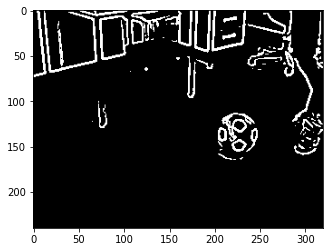

In [12]:
test = cv2.imread(f'{list_path[0]}', 0)
test = use_filter2d(test)
plt.imshow(test, cmap='gray')
plt.show()

In [13]:
def get_pair_keypoints(left_img, right_img):
    left_gray_img = cv2.cvtColor(left_img, cv2.COLOR_BGR2GRAY)
    left_gray_img = use_filter2d(left_gray_img)
    left_gray_img = left_gray_img.astype(np.uint8)
    
    right_gray_img = cv2.cvtColor(right_img ,cv2.COLOR_BGR2GRAY) 
    right_gray_img = use_filter2d(right_gray_img)
    right_gray_img = right_gray_img.astype(np.uint8)

    # Initiate SIFT detector
    sift = cv2.SIFT_create()

    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(left_gray_img,None)
    kp2, des2 = sift.detectAndCompute(right_gray_img,None)

    # BFMatcher with default params
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1,des2,k=2)

    # Apply ratio test
    good = []
    left_points = []
    right_points = []
    for m,n in matches:
        if m.distance < 0.95*n.distance:
            good.append([m])
            #print('Image 1 point:', kp1[m.queryIdx].pt)
            #print('Image 2 point:', kp2[m.trainIdx].pt)
            #print('------------')
            left_points.append(kp1[m.queryIdx].pt)
            right_points.append(kp2[m.trainIdx].pt)
    # remove duplicated points
    rm_index = []
    exist_point = []
    for idx, p in enumerate(left_points):
        if p not in exist_point:
            exist_point.append(p)
        else:
            rm_index.append(idx)
    rm_index.reverse()
    for idx in rm_index:
        del left_points[idx]
        del right_points[idx]
#     img3 = cv2.drawMatchesKnn(left_img,kp1,right_img,kp2,good,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
#     plt.imshow(img3)
#     plt.show()

    return left_img, right_img, left_points, right_points

# Define mean-shift 

In [14]:
def implement_mean_shift(X, data, bbox2_point1, bbox2_point2, frame, max_iter):
    height2, width2 = np.abs(bbox2_point1[1]-bbox2_point2[1]), np.abs(bbox2_point1[0]-bbox2_point2[0])
    x_root, y_root = bbox2_point1[0] + width2/2, bbox2_point1[1] + height2/2
    ratio = np.linspace(0.75, 1.25, max_iter)
    multi_height2, multi_width2 = height2*ratio, width2*ratio
    temp = []
    
    for height2, width2 in zip(multi_height2, multi_width2):
        bbox2_point1 = (int(x_root - width2/2), int(y_root - height2/2))
        bbox2_point2 = (int(x_root + width2/2), int(y_root + height2/2))
        x_old, y_old = x_root, y_root

        for _ in range(10):
            M00, M10, M01 = 0, 0, 0
            for y in range(bbox2_point1[1], bbox2_point2[1]):
                for x in range(bbox2_point1[0], bbox2_point2[0]):
                    M00 += X[y, x]
                    M10 += X[y, x] * x
                    M01 += X[y, x] * y
            
            x_new, y_new = M10/(M00+1e-4), M01/(M00+1e-4)
            err = (x_new - x_old)**2 + (y_new - y_old)**2
            if err < 5:
                break
            x_old, y_old = x_new, y_new
        bbox2_point1 = (int(x_new - width2/2), int(y_new - height2/2))
        bbox2_point2 = (int(x_new + width2/2), int(y_new + height2/2))
        
        IoU = evaluate(data, frame, bbox2_point1, bbox2_point2)
        temp.append([IoU, bbox2_point1, bbox2_point2])
        
    temp.sort(key = lambda X: X[0])
    bbox2_point1, bbox2_point2 = temp[-1][1:]
        
    return bbox2_point1, bbox2_point2

# Define evaluate function IoU 

In [15]:
def init_bbox(data, frame):
    bbox2_point1 = (data[frame-1][2], data[frame-1][3])
    bbox2_point2 = (data[frame-1][-2], data[frame-1][-1])
    return bbox2_point1, bbox2_point2

def evaluate(data, frame, bbox2_point1, bbox2_point2):
    bbox1_point1 = (data[frame-1][2], data[frame-1][3])
    bbox1_point2 = (data[frame-1][-2], data[frame-1][-1])
    height1, width1 = np.abs(bbox1_point1[1]-bbox1_point2[1]), np.abs(bbox1_point1[0]-bbox1_point2[0])
    
    height2, width2 = np.abs(bbox2_point1[1]-bbox2_point2[1]), np.abs(bbox2_point1[0]-bbox2_point2[0])
    
    x1 = max(bbox1_point1[0], bbox2_point1[0])
    y1 = max(bbox1_point1[1], bbox2_point1[1])
    x2 = min(bbox1_point2[0], bbox2_point2[0])
    y2 = min(bbox1_point2[1], bbox2_point2[1])
    
    intersection_area = (x2-x1)*(y2-y1)
    intersection_area = intersection_area if intersection_area > 0 else 0
    
    if intersection_area == 0:
        return 0
    
    union_area = height1*width1 + height2*width2 - intersection_area
    
    return intersection_area / union_area

In [16]:
cap = cv2.VideoCapture('Input_video.avi')
out = cv2.VideoWriter('result.avi',cv2.VideoWriter_fourcc(*'DIVX'), 20, size)
frame = 0
skip = 0
reinit = 0
success = 0

while True:
    ret, img = cap.read()
    frame += 1
    
    if ret:
        if frame == 1:
            bbox2_point1, bbox2_point2 = init_bbox(data, frame)
            object_ = img[bbox2_point1[1]:bbox2_point2[1], bbox2_point1[0]:bbox2_point2[0]]
#             height, width, channel = object_.shape
            skip = 5

        if (reinit == 1) and (skip == 0):
            bbox2_point1, bbox2_point2 = init_bbox(data, frame)
            object_ = img[bbox2_point1[1]:bbox2_point2[1], bbox2_point1[0]:bbox2_point2[0]]
#             height, width, channel = object_.shape
            skip = 5
            reinit = 0
        if (reinit == 1) and (skip == 0):
            bbox2_point1, bbox2_point2 = init_bbox(data, frame)
            object_ = img[bbox2_point1[1]:bbox2_point2[1], bbox2_point1[0]:bbox2_point2[0]]
#             height, width, channel = object_.shape
            skip = 5
            reinit = 0

        if skip == 0:
            try:
                left_img, right_img, left_points, right_points = get_pair_keypoints(object_, img)
                gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

                right_points = np.array(right_points).astype(np.uint32)

                x, y = right_points[:, 0], right_points[:, 1]

                prob_map = np.zeros(gray.shape)
                prob_map[y, x] = np.where(True, 1, 0)
                prob_map = cv2.GaussianBlur(prob_map, (11, 11), -1)
                prob_map = cv2.GaussianBlur(prob_map, (7, 7), -1)
                prob_map = cv2.GaussianBlur(prob_map, (7, 7), -1)

                bbox2_point1, bbox2_point2 = implement_mean_shift(prob_map, data, bbox2_point1, bbox2_point2, frame, max_iter=5)
                
                object_ = img[bbox2_point1[1]:bbox2_point2[1], bbox2_point1[0]:bbox2_point2[0]]
#                 height, width, channel = object_.shape

                IoU = evaluate(data, frame, bbox2_point1, bbox2_point2)

                if IoU > 0.5:
                    success += 1
                    cv2.rectangle(img, bbox2_point1, bbox2_point2, (0, 255, 0), 2)
                else:
                    skip = 5
                    reinit = 1
            except:
                skip = 5
                reinit = 1
        
#         cv2.imshow('Video', img)
        out.write(img)
        if skip > 0:
            skip -= 1
    
    if (cv2.waitKey(1) == ord('e')) or not(ret):
        break

cap.release()
cv2.destroyAllWindows()
out.release()
print(success)

577
